In [13]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from deepxde.backend import tf

In [2]:
df = pd.read_csv('1550 Airfoil_data.csv')
x_domain = df['Points:0']
y_domain = df['Points:1']
u_exact = df[('U:0')]
v_exact = df[('U:1')]
p_exact = df[('p')]
X1 = np.column_stack((x_domain,y_domain))
y = np.column_stack((u_exact,v_exact,p_exact))

(-0.5, 0.5)

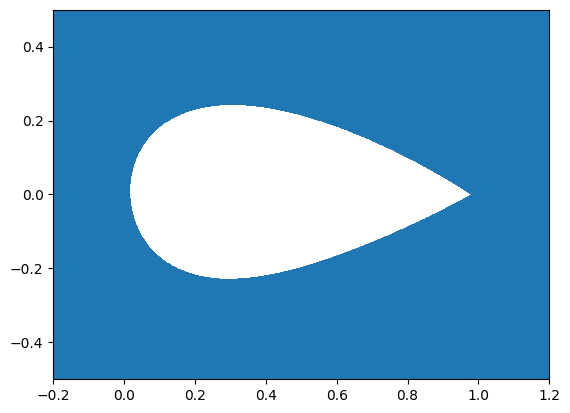

In [3]:
plt.scatter(X1[:,0],X1[:,1])
plt.xlim(-0.2,1.2)
plt.ylim(-0.5,0.5)

In [4]:
x_geo = []
y_geo = []
for i in range (len(x_domain)):
    if u_exact[i] == 0 and v_exact[i] == 0:
        x_geo.append(x_domain[i])
        y_geo.append(y_domain[i])
        
X = np.column_stack((x_geo,y_geo))
print(X)

[[ 2.3502e-04 -4.5006e-04]
 [ 1.9567e-04  5.3769e-04]
 [ 2.7939e-04 -1.4698e-03]
 ...
 [ 1.0000e+00  1.1718e-03]
 [ 1.0000e+00  1.2635e-03]
 [ 1.0000e+00  1.3603e-03]]


The maximum value of x is : 1.0
The maximum value of y is : 0.25845
The minimum value of x is : -2.7612e-07
The minimum value of y is : -0.24166


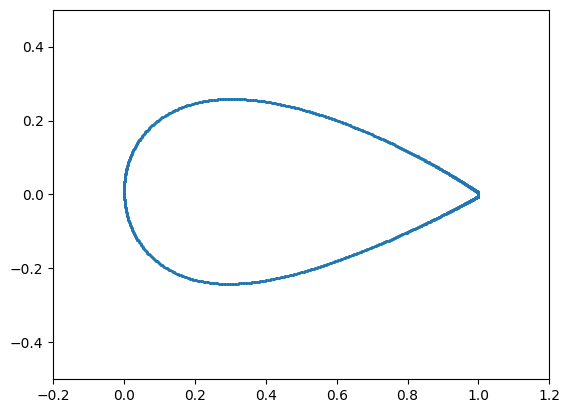

In [5]:
plt.scatter(x_geo,y_geo,s=1)
plt.xlim(-0.2,1.2)
plt.ylim(-0.5,0.5)
print("The maximum value of x is :",np.max(x_geo))
print("The maximum value of y is :",np.max(y_geo))
print("The minimum value of x is :",np.min(x_geo))
print("The minimum value of y is :",np.min(y_geo))

In [6]:
Re = 100 # Reynold's number

In [7]:
x_max = 1
y_max = 1
x_min = -1
y_min = -1
eta = 0

Airfoil_points = np.column_stack((x_geo,y_geo)).tolist()

Domain_geometry = dde.geometry.Polygon([
    [x_min,y_min],[x_min,y_max],[x_max,y_max],[x_max,eta], *Airfoil_points,[x_max,-eta],[x_max,y_min]
])

Points = [[x_min,y_min],[x_min,y_max],[x_max,y_max],[x_max,eta], *Airfoil_points,[x_max,-eta],[x_max,y_min]]
print("Domain geometry points:")
for point in (Points):
    print(point)

Domain geometry points:
[-1, -1]
[-1, 1]
[1, 1]
[1, 0]
[0.00023502, -0.00045006]
[0.00019567, 0.00053769]
[0.00027939, -0.0014698]
[0.00016098, 0.0014936]
[0.00013062, 0.0024177]
[0.00032914, -0.0025216]
[0.00010427, 0.0033102]
[0.00038466, -0.0036056]
[8.1637e-05, 0.0041712]
[0.00044637, -0.0047219]
[6.2414e-05, 0.0050008]
[4.632e-05, 0.0057993]
[0.00051469, -0.0058705]
[3.3082e-05, 0.0065668]
[0.00059005, -0.0070515]
[2.2437e-05, 0.0073033]
[1.4134e-05, 0.0080093]
[0.00067292, -0.0082649]
[7.9348e-06, 0.0086847]
[3.6094e-06, 0.0093299]
[0.00076375, -0.0095108]
[9.4105e-07, 0.009945]
[-2.7612e-07, 0.01053]
[0.00086304, -0.010789]
[-2.3684e-07, 0.011086]
[8.7531e-07, 0.011612]
[2.8878e-06, 0.012109]
[0.00097129, -0.0121]
[5.6392e-06, 0.012577]
[8.9786e-06, 0.013016]
[1.2766e-05, 0.013427]
[0.001089, -0.013443]
[1.6873e-05, 0.01381]
[2.1179e-05, 0.014165]
[2.5576e-05, 0.014492]
[2.9965e-05, 0.014792]
[0.0012167, -0.014819]
[3.5145e-05, 0.01512]
[4.1225e-05, 0.015474]
[4.8321e-05, 0.0158

In [8]:
def Governing_equation(x,y):
    # Note that X[0] is x cordinate of domain and X[1] is y cordiante of domain
    # And Y[0] is the u velocity, Y[1] is the v velocity and Y[2] is the pressure
    u = y[:,0:1]
    v = y[:,1:2]
    p = y[:,2:3]

    du = tf.gradients(u,x)[0]
    dv = tf.gradients(v,x)[0]
    dp = tf.gradients(p,x)[0]

    p_x,p_y = dp[:,0:1], dp[:,1:2]
    u_x,u_y = du[:,0:1], dv[:,1:2]
    v_x,v_y = dv[:,0:1], dv[:,1:2]

    u_xx = tf.gradients(u_x,x)[0][:,0:1]
    u_yy = tf.gradients(u_y,x)[0][:,1:2]

    v_xx = tf.gradients(v_x,x)[0][:,0:1]
    v_yy = tf.gradients(v_y,x)[0][:,1:2]
    
    Continuity_equation = u_x + v_y
    X_momentum = u*u_x + v*u_y + p_x - (1/Re)*(u_xx + u_yy)
    Y_momentum = u*v_x + v*v_y + p_y - (1/Re)*(v_xx + v_yy)
    return [Continuity_equation , X_momentum , Y_momentum]

In [9]:
'''
# Inflow bundary condition
inlet_velocity = 1
def inflow_boundary(x,on_boundary):
    return np.isclose(x[:,0] , x_min)
def inflow_func(x,_):
    return np.array([inlet_velocity,0,0])
bc_inflow = dde.icbc.DirichletBC(Domain_geometry,Governing_equation,inflow_func,inflow_boundary)

# Outflow boundary condition
def outflow_boundary(x,on_boundary):
    return on_boundary and (np.isclose(x[:,0] , x_max) or np.isclose(x[:,1] , y_max) or np.isclose(x[:,1] , y_min))
def outflow_func(x,_):
    return np.zeros([len(x),3])
bc_outflow = dde.icbc.NeumannBC(Domain_geometry,Governing_equation,outflow_func,outflow_boundary)

# No slip boundary condition
def airfoil_boundary(x,on_boundary):
    return np.isclose(x[:,0] , x_geo) and np.isclose(x[:,1] , y_geo)
def airfoil_func(x,_):
    return np.zeros([len(x),3])
bc_airfoil = dde.icbc.DirichletBC(Domain_geometry,Governing_equation,airfoil_func,airfoil_boundary)
'''

'\n# Inflow bundary condition\ninlet_velocity = 1\ndef inflow_boundary(x,on_boundary):\n    return np.isclose(x[:,0] , x_min)\ndef inflow_func(x,_):\n    return np.array([inlet_velocity,0,0])\nbc_inflow = dde.icbc.DirichletBC(Domain_geometry,Governing_equation,inflow_func,inflow_boundary)\n\n# Outflow boundary condition\ndef outflow_boundary(x,on_boundary):\n    return on_boundary and (np.isclose(x[:,0] , x_max) or np.isclose(x[:,1] , y_max) or np.isclose(x[:,1] , y_min))\ndef outflow_func(x,_):\n    return np.zeros([len(x),3])\nbc_outflow = dde.icbc.NeumannBC(Domain_geometry,Governing_equation,outflow_func,outflow_boundary)\n\n# No slip boundary condition\ndef airfoil_boundary(x,on_boundary):\n    return np.isclose(x[:,0] , x_geo) and np.isclose(x[:,1] , y_geo)\ndef airfoil_func(x,_):\n    return np.zeros([len(x),3])\nbc_airfoil = dde.icbc.DirichletBC(Domain_geometry,Governing_equation,airfoil_func,airfoil_boundary)\n'

In [10]:
# If we assume that the gauge pressure at the free stream is zero then the inlet condtion w=can be written as [U,V,P] = [U,0,0]
# Inflow boundary condition
def Inflow_Boundary_condition(x,on_boundary):
    '''Check for the points on left side of the domain'''
    return on_boundary and np.isclose(x[0],x_min)

def Inflow_X_velocity_value(x):
    '''The velocity at the inlet is just inlet velocity with no profile (uniform)'''
    u_inlet = 1
    uniform_velocity = np.full((x.shape[0],1),u_inlet)
    return uniform_velocity.reshape(-1,1)
def zero_velocity(x):
    '''Zero velocity'''
    return np.zeros((x.shape[0],1))
def zero_gauge_pressure(x):
    '''Zero velocity'''
    return np.zeros((x.shape[0],1))
    
# The following code will defien the inlet boundary condition on the values of U,V,P
X_Velocity_Inlet_bc = dde.icbc.DirichletBC(Domain_geometry,Inflow_X_velocity_value,Inflow_Boundary_condition,component=0)
Y_Velocity_Inlet_bc = dde.icbc.DirichletBC(Domain_geometry,zero_velocity,Inflow_Boundary_condition,component=1)


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
# Outflow Boundary Condition
def Outflow_Boundary_condition(x,on_boundary):
    '''Check for the points on the top, right and back of the rectangular domain'''
    return on_boundary and (np.isclose(x[0],x_max) or np.isclose(x[1],y_min) or np.isclose(x[1],y_min))
def Outflow_Stress_values(x):
    '''Implements the stress at the boundary to be zero'''
    return np.zeros((x.shape[0],1))
    
X_Velocity_Outflow_bc = dde.icbc.NeumannBC(Domain_geometry,Outflow_Stress_values,Outflow_Boundary_condition,component=0)
Y_Velocity_Outflow_bc = dde.icbc.NeumannBC(Domain_geometry,Outflow_Stress_values,Outflow_Boundary_condition,component=1)



''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
'''
Airfoil dimensions:-
The maximum value of x is : 1.0
The maximum value of y is : 0.25845
The minimum value of x is : -2.7612e-07
The minimum value of y is : -0.24166
'''
# The boundary condition at the boundary of airfoil
def Airfoil_Boundary_condition(x,on_boundary):
    '''Check for the points on the top, right and back of the rectangular domain'''
    return on_boundary and (x[0]< 1.0 and x[0] > -2.7612e-07) and (x[1] < 0.25845 and x[1] > -0.24166)

def Airfoil_Velocity_values(x):
    '''Implements the velocity on airfoil to be zero'''
    return np.zeros((x.shape[0],1))
    
X_velocity_Airfoil_bc = dde.icbc.DirichletBC(Domain_geometry,Airfoil_Velocity_values,Airfoil_Boundary_condition,component=0)
Y_velocity_Airfoil_bc = dde.icbc.DirichletBC(Domain_geometry,Airfoil_Velocity_values,Airfoil_Boundary_condition,component=1)


data = dde.data.PDE(
    Domain_geometry,
    Governing_equation, 
    [X_Velocity_Inlet_bc,X_Velocity_Outflow_bc,Y_Velocity_Outflow_bc,X_velocity_Airfoil_bc,Y_velocity_Airfoil_bc], 
    num_domain=2540, 
    num_boundary=80, 
)


In [11]:
layer_size = [2] + [50]*3 + [3]
net = dde.nn.FNN(layer_size,"relu","Glorot uniform")
model = dde.Model(data, net)

In [12]:
model.compile("adam", lr=1e-3)
model.train(iterations=15000)
model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
Building feed-forward neural network...
'build' took 0.271124 s


'compile' took 6.907811 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [1.60e-02, 1.26e-01, 8.70e-02, nan, 2.05e-03, 1.89e-03, 3.06e-04, 3.46e-04]         [1.60e-02, 1.26e-01, 8.70e-02, nan, 2.05e-03, 1.89e-03, 3.06e-04, 3.46e-04]         []  

Best model at step 0:
  train loss: inf
  test loss: inf
  test metric: 

'train' took 2.001937 s

Compiling model...
'compile' took 5.480986 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
1         [1.07e-02, 4.48e-02, 1.15e-02, nan, 1.20e-03, 1.34e-03, 1.51e-04, 1.77e-04]         [1.07e-02, 4.48e-02, 1.15e-02, nan, 1.20e-03, 1

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [22]:
a = 1,2,3,4,5,6,7,8,9
b = 1,2,3,4,5,6,7,8,9
c = np.column_stack((a,b)).T
print(c[1])


[2 2]
